# 🏥 Heart Attack Prediction: K-Nearest Neighbors (KNN) Implementation

This specialized notebook focuses on the **KNN (K-Nearest Neighbors)** algorithm. KNN is a non-parametric, instance-based learning algorithm that classifies a patient's risk based on the similarity of their medical metrics to others in the dataset.

### 🔑 Critical Note: Feature Scaling
Since KNN calculates **Euclidean distance**, features with larger ranges (like Cholesterol) can dominate the results. We will implement `preprocessing.StandardScaler` to ensure all medical features contribute equally to the final prediction.

In [2]:
# Core data science libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns # For high-quality visualizations

# Scaling and Preprocessing
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

# Model specific & Metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

## 🔍 Data Exploration & Statistical Analysis

Before building the KNN model, we perform an intensive **Exploratory Data Analysis (EDA)**. Our goals are:
1. **Distribution Check**: Understanding how clinical features like Blood Pressure and Age are distributed.
2. **Class Balance**: Checking if the dataset is balanced between 'High Risk' and 'Low Risk' patients.
3. **Value Inspection**: Identifying unique values in categorical features (Sex, Chest Pain, etc.) to ensure data integrity.

Dataset Dimensions: 303 rows, 14 columns


,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1



Statistical Insights:


,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000



Target Distribution (0: Low Risk, 1: High Risk):
output
1    54.455446
0    45.544554
Name: proportion, dtype: float64

Feature Value Frequencies:
age: 41 unique values
sex: 2 unique values
cp: 4 unique values
trtbps: 49 unique values
chol: 152 unique values
fbs: 2 unique values
restecg: 3 unique values
thalachh: 91 unique values
exng: 2 unique values
oldpeak: 40 unique values
slp: 3 unique values
caa: 5 unique values
thall: 4 unique values
output: 2 unique values


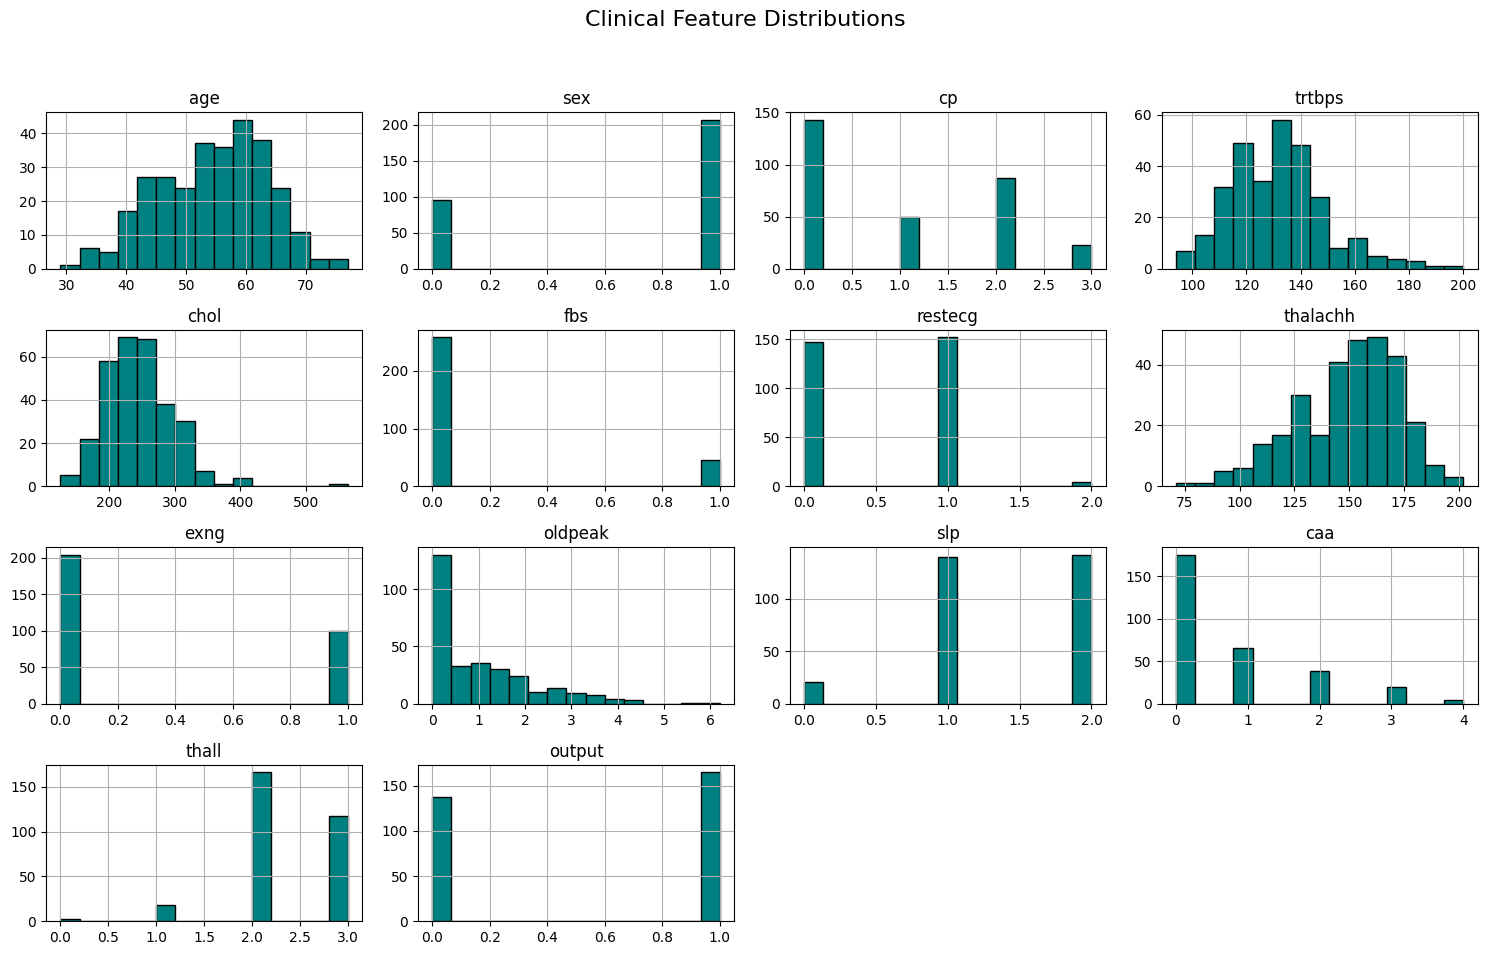

In [3]:
# Load dataset
df = pd.read_csv("../data/heart.csv")

# 1. Structural Overview
print(f"Dataset Dimensions: {df.shape[0]} rows, {df.shape[1]} columns")
display(df.head())

# 2. Statistical Summary
print("\nStatistical Insights:")
display(df.describe())

# 3. Target Variable Balance
print("\nTarget Distribution (0: Low Risk, 1: High Risk):")
print(df["output"].value_counts(normalize=True) * 100) # Percentage view

# 4. Feature Value Inspection
# Printing unique value counts for each feature to understand data variety
print("\nFeature Value Frequencies:")
for col in df.columns:
    print(f"{col}: {df[col].nunique()} unique values")

# 5. Visual Distribution
# Using histograms to visualize the spread of medical data
df.hist(bins=15, figsize=(15, 10), color='teal', edgecolor='black')
plt.suptitle("Clinical Feature Distributions", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## 🧱 Feature Engineering & Matrix Construction

To prepare the data for the KNN algorithm, we extract the independent variables (Features) and the dependent variable (Target).

* **X (Feature Matrix)**: Contains clinical attributes such as age, blood pressure, and cholesterol levels.
* **y (Target Vector)**: Contains the labels (0 for low risk, 1 for high risk).

Converting these to **NumPy arrays** ensures high-performance computation during the distance-calculation phase of KNN.

In [4]:
# Selecting all clinical features for the X matrix
# Note: Ensure column names match your dataset (e.g., 'thalachh' or 'thalach')
X = df[['age', 'sex', 'cp', 'trtbps', 'chol', 'fbs', 'restecg', 
        'thalachh', 'exng', 'oldpeak', 'slp', 'caa', 'thall']].values

# Selecting the target variable 'output'
y = df['output'].values # Using .values for a 1D array is better for the target

# Displaying the first 5 entries to verify the transformation
print("--- Feature Matrix (X) First 5 Rows ---")
print(X[:5])

print("\n--- Target Vector (y) First 5 Labels ---")
print(y[:5])

--- Feature Matrix (X) First 5 Rows ---
[[ 63.    1.    3.  145.  233.    1.    0.  150.    0.    2.3   0.    0.
    1. ]
 [ 37.    1.    2.  130.  250.    0.    1.  187.    0.    3.5   0.    0.
    2. ]
 [ 41.    0.    1.  130.  204.    0.    0.  172.    0.    1.4   2.    0.
    2. ]
 [ 56.    1.    1.  120.  236.    0.    1.  178.    0.    0.8   2.    0.
    2. ]
 [ 57.    0.    0.  120.  354.    0.    1.  163.    1.    0.6   2.    0.
    2. ]]

--- Target Vector (y) First 5 Labels ---
[1 1 1 1 1]


## ⚖️ Feature Standardization

KNN is a distance-based algorithm (Euclidean distance). To prevent features with large magnitudes from dominating the model, we apply **Standardization**.

We use `StandardScaler` to transform the data such that:
* **Mean ($\mu$)** of each feature becomes **0**.
* **Standard Deviation ($\sigma$)** becomes **1**.

This ensures that all clinical parameters are treated with equal importance during the classification process.

In [5]:
# Initialize the StandardScaler and fit it to our features
scaler = preprocessing.StandardScaler().fit(X)

# Transform the data to a standardized scale
# Converting to float ensures precision during mathematical calculations
X = scaler.transform(X.astype(float))

# Preview the results
print("✅ Features standardized successfully.")
print("\n--- Standardized Feature Matrix (First 5 Rows) ---")
print(X[0:5])

print("\n--- Target Labels (First 5 Entries) ---")
print(y[0:5])

✅ Features standardized successfully.

--- Standardized Feature Matrix (First 5 Rows) ---
[[ 0.9521966   0.68100522  1.97312292  0.76395577 -0.25633371  2.394438
  -1.00583187  0.01544279 -0.69663055  1.08733806 -2.27457861 -0.71442887
  -2.14887271]
 [-1.91531289  0.68100522  1.00257707 -0.09273778  0.07219949 -0.41763453
   0.89896224  1.63347147 -0.69663055  2.12257273 -2.27457861 -0.71442887
  -0.51292188]
 [-1.47415758 -1.46841752  0.03203122 -0.09273778 -0.81677269 -0.41763453
  -1.00583187  0.97751389 -0.69663055  0.31091206  0.97635214 -0.71442887
  -0.51292188]
 [ 0.18017482  0.68100522  0.03203122 -0.66386682 -0.19835726 -0.41763453
   0.89896224  1.23989692 -0.69663055 -0.20670527  0.97635214 -0.71442887
  -0.51292188]
 [ 0.29046364 -1.46841752 -0.93851463 -0.66386682  2.08204965 -0.41763453
   0.89896224  0.58393935  1.43548113 -0.37924438  0.97635214 -0.71442887
  -0.51292188]]

--- Target Labels (First 5 Entries) ---
[1 1 1 1 1]


## 🧪 Train/Test Split

To rigorously evaluate our KNN model, we partition our standardized data into two subsets:
1. **Training Set (80%)**: Used to let the algorithm "learn" the relationship between clinical features and heart attack risk.
2. **Testing Set (20%)**: Acts as unseen data to provide an unbiased evaluation of the final model.

We maintain a `random_state` to ensure that our experiments are consistent and reproducible.

In [6]:
# Split the data into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Printing dimensions to confirm the split
print("Data Split Summary:")
print(f"Training Features: {X_train.shape}")
print(f"Training Labels:   {y_train.shape}")
print(f"Testing Features:  {X_test.shape}")
print(f"Testing Labels:   {y_test.shape}")

print("\nVerification: The training set contains 80% of the total samples.")

Data Split Summary:
Training Features: (242, 13)
Training Labels:   (242,)
Testing Features:  (61, 13)
Testing Labels:   (61,)

Verification: The training set contains 80% of the total samples.


## 🤖 KNN Model Implementation (K=6)

In this stage, we initialize the **K-Nearest Neighbors** classifier with an initial value of **K=6**. 

* **Training**: The model learns by mapping the standardized clinical features of the training set.
* **Inference**: We then challenge the model to predict the heart attack risk for the unseen 20% of patients in our testing set.
* **Comparison**: By comparing the first 10 predictions (`y_hat`) with the actual clinical outcomes (`y_test`), we get a preliminary sense of the model's accuracy.

In [7]:
from sklearn.neighbors import KNeighborsClassifier

# Initialize and train the model with K=6
k = 6
knn_model = KNeighborsClassifier(n_neighbors=k)
knn_model.fit(X_train, y_train)

# Perform predictions on the test dataset
y_hat = knn_model.predict(X_test)

# Displaying a comparative table for the first 10 predictions
print(f"Model Performance - Initial Results (K={k})")
print("-" * 45)
print(f"Predicted Labels: {y_hat[0:10]}")
print(f"Actual Labels:    {y_test[0:10]}")
print("-" * 45)
print(f"Total predictions made: {len(y_hat)}")

Model Performance - Initial Results (K=6)
---------------------------------------------
Predicted Labels: [0 0 1 0 1 1 1 0 0 1]
Actual Labels:    [0 0 1 0 1 1 1 0 0 1]
---------------------------------------------
Total predictions made: 61


## 🎯 Hyperparameter Tuning: Finding the Optimal K

The performance of KNN is highly dependent on the value of **K** (number of neighbors). 
* A **small K** can lead to *Overfitting* (sensitive to noise).
* A **large K** can lead to *Underfitting* (too smooth).

We iterate through values $K=2$ to $K=10$ and track the **Accuracy** and **Standard Deviation** to identify the "Sweet Spot" where the model generalizes best on unseen data.

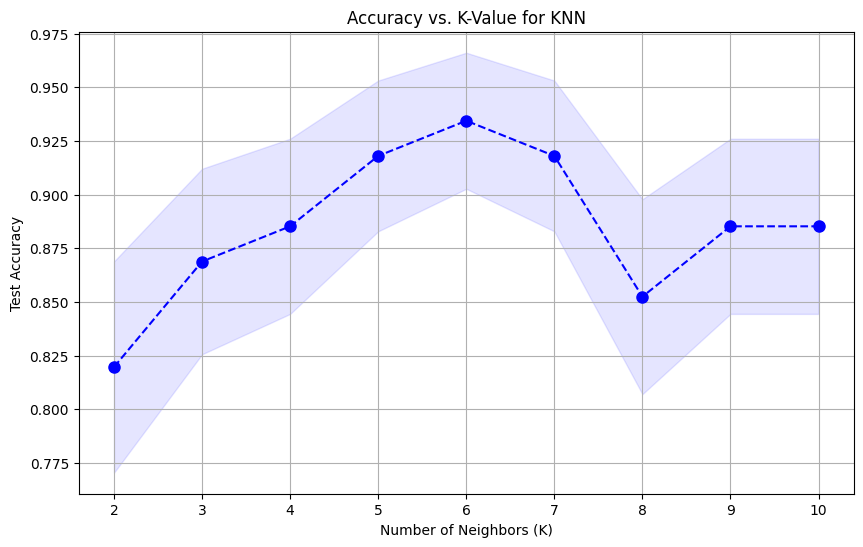

The best accuracy was 0.9344 with K = 6


In [10]:
from sklearn.metrics import accuracy_score

ks = range(2, 11)
mean_acc = []
std_acc = []

for k in ks:
    # Train Model and Predict  
    neigh_model = KNeighborsClassifier(n_neighbors=k).fit(X_train, y_train)
    yhat = neigh_model.predict(X_test)
    
    # Calculate Accuracy
    mean_acc.append(accuracy_score(y_test, yhat))
    
    # Calculate Standard Deviation for error bars
    std_acc.append(np.std(yhat == y_test) / np.sqrt(yhat.shape[0]))

# --- Visualization of Results ---
plt.figure(figsize=(10, 6))
plt.plot(ks, mean_acc, color='blue', marker='o', linestyle='dashed', markersize=8)
plt.fill_between(ks, 
                 np.array(mean_acc) - 1 * np.array(std_acc), 
                 np.array(mean_acc) + 1 * np.array(std_acc), 
                 alpha=0.10, color='blue')

plt.title('Accuracy vs. K-Value for KNN')
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Test Accuracy')
plt.xticks(ks)
plt.grid(True)
plt.show()

print(f"The best accuracy was {max(mean_acc):.4f} with K = {ks[np.argmax(mean_acc)]}")